# Overlapping Mixture Model with movie data

In [1]:
%load_ext autoreload
%autoreload 2
import utils, omm
import random
import pandas as pd
import numpy as np

In [4]:
Z = pd.read_csv('clusters_matrix.csv', sep=',', index_col=0)
X = pd.read_csv('binary_data_matrix.csv', sep=',', index_col=0)
#X.columns = X.columns.astype(int)
#Z.columns = Z.columns.astype(int)
X = X.as_matrix()
Z = Z.as_matrix()

#Generate movies data
nbr_clear = 1
X = X[0:200]

while nbr_clear > 0:
    X, nbr_clear = utils.clear_movies(X)
    X, nbr_clear = utils.clear_users(X)

X = X[0:150] 
Z = Z[0:150]


list_random_rows = random.sample(range(150), 150)
X = utils.get_mat_random(X, list_random_rows)
Z = utils.get_mat_random(Z, list_random_rows)
U=np.dot(Z,Z.T)

In [5]:
#Algorithm initialization
K=Z.shape[1]
N=Z.shape[0]
n_train=50
D=X.shape[1]
N_iter=300
alpha_prior = 10
burning_period=100
omega = 1

theta= utils.random_theta(N,K,D,alpha_prior)

In [ ]:
%%capture
#We try a first time the OMM algorithm to get a sense of how good the model is
IOMM = omm.IOMM(N = N, 
                 K = K, 
                 D = D, 
                 N_iter = N_iter, 
                 Z = Z, 
                 X = X, 
                 theta = theta, 
                 alpha_prior = alpha_prior, 
                 omega = omega,
                 copy_rows = n_train,
                 burning_period=burning_period)

Z_hat,theta_resampled,Z_hat_mean,U_hat = IOMM.learning(apply_log=False,random_walk=False)

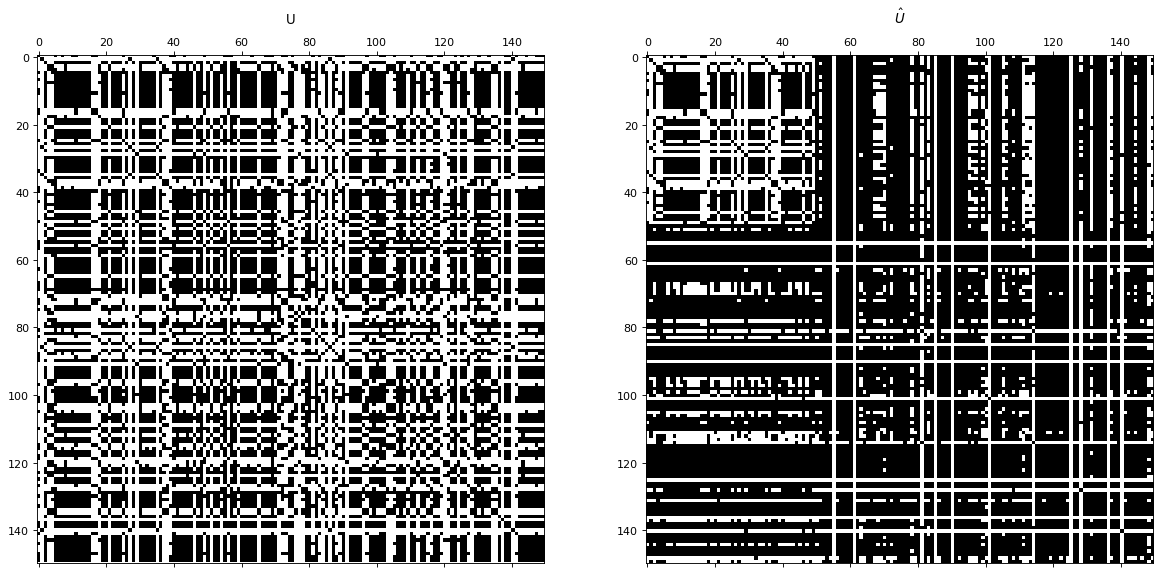

In [13]:
#We plot U and the U_hat we get
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('U')
ax2.title.set_text('$\hat{U}$')

ax1.spy(U)
ax2.spy(U_hat)

plt.show()

In [14]:
# summmary statistics
U_diff=abs(U-U_hat)
print("% of pairs having same number of clusters:",len(U_diff[U_diff<1])/(N*N))
print("% of pairs having at most 1 cluster difference:",len(U_diff[U_diff<2])/(N*N))
print("% of pairs having at most 2 clusters difference:",len(U_diff[U_diff<3])/(N*N))
print("% of pairs having at most 3 clusters difference:",len(U_diff[U_diff<4])/(N*N))

% of pairs having same number of clusters: 0.6985777777777777
% of pairs having at most 1 cluster difference: 0.8743111111111111
% of pairs having at most 2 clusters difference: 0.9085333333333333
% of pairs having at most 3 clusters difference: 0.9196444444444445


In [24]:
%%capture
#This time we run several times the algorithm to study variance of its predictions
cols = ["zero", "one", "two", "three"]
clusters_differences = {
    'U_hat_list': [],
}
for i in range(len(cols)):
    clusters_differences[cols[i]] = []

for i in range(10):
    IOMM = omm.IOMM(N = N, 
                     K = K, 
                     D = D, 
                     N_iter = N_iter, 
                     Z = Z, 
                     X = X, 
                     theta = theta, 
                     alpha_prior = alpha_prior, 
                     omega = omega,
                     copy_rows = n_train,
                     burning_period=burning_period)
    Z_hat,theta_resampled,Z_hat_mean,U_hat = IOMM.learning(apply_log=False,random_walk=False)
    U_hat_new = np.copy(U_hat)
    U_diff=abs(U-U_hat_new)
    clusters_differences['U_hat_list'].append(U_hat_new)
    for j in range(len(cols)):
        clusters_differences[cols[j]].append(len(U_diff[U_diff<j+1])/(N*N))

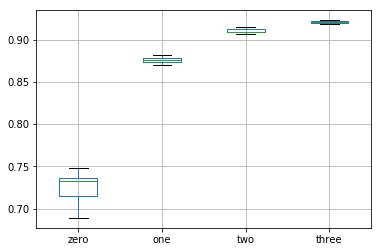

In [25]:
clusters_differences_df = pd.DataFrame.from_dict(clusters_differences)[cols]
#clusters_differences_df.head()
clusters_differences_df.boxplot()